In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter


import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

W0923 14:41:44.344271 140521660213056 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0923 14:41:44.345919 140521660213056 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0923 14:41:44.356919 140521660213056 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [3]:
path = '/home/ricardo/TCC/'

In [4]:
df = pd.read_csv(path+'train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']

In [5]:
meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

In [6]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X_norm.loc[fraud_index]
honest = X_norm.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

In [7]:
h_used, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)
x_used = pd.concat([h_used,fraud],ignore_index = False)
y_used = pd.concat([yh,yf],ignore_index=False)
x_train,x_test,y_train,y_test = train_test_split(x_used,y_used,test_size=0.3,random_state = 30)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state = 30)

In [8]:
x_data = [x_train,x_val,x_test]
y_data = [y_train,y_val,y_test]

print('Size of Train Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[0]),Counter(y_data[0])))
print('Size of val Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[1]),Counter(y_data[1])))
print('Size of test Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[2]),Counter(y_data[2])))

Size of Train Data: 45551, not anomalys/anomaly:Counter({0: 31412, 1: 14139})
Size of val Data: 9761, not anomalys/anomaly:Counter({0: 6779, 1: 2982})
Size of test Data: 9761, not anomalys/anomaly:Counter({0: 6784, 1: 2977})


In [9]:
def f1Score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [10]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [11]:
model = models.Sequential()
model.add(layers.Dense(units = 50, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model.add(layers.Dense(units = 50, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))
model.summary()

W0923 14:42:02.785795 140521660213056 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0923 14:42:02.788663 140521660213056 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0923 14:42:02.836369 140521660213056 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


In [12]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

W0923 14:42:02.901912 140521660213056 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0923 14:42:02.913778 140521660213056 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


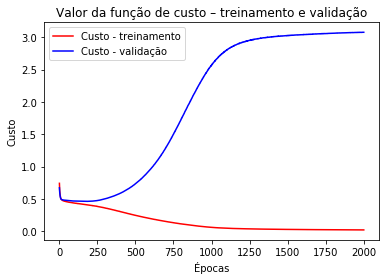

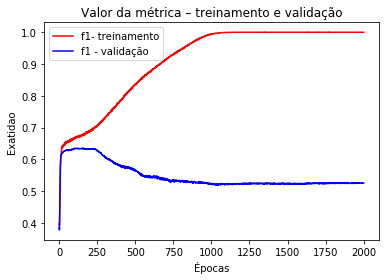

In [13]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [14]:
def choosing_threshold(y_true,y_prob,threshold_list):
    y_hat = []
    precision = []
    recall = []
    f1 = []
    y_h = []
    for threshold in threshold_list:
        for i in range(len(y_true)):
            if y_prob[i]>threshold:
                y_hat.append(1)
            else:
                y_hat.append(0)
        precision.append(precision_score(y_true,y_hat))
        recall.append(recall_score(y_true,y_hat))
        f1.append(f1_score(y_true,y_hat))
        y_h.append(y_hat)
        y_hat = []
    return(precision,recall,f1,y_h)                       

In [15]:
prob = np.ravel(model.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

In [16]:
print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.9974603174603175, 0.99992927864215, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
recall values: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999292736402857, 0.9972416719711437, 0.9335879482283047]
f1 values: [0.9987285441830898, 0.9999646380706531, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999646355695441, 0.9986189312652715, 0.9656534620871283]


Normalized confusion matrix
[[0.99885394 0.00114606]
 [0.         1.        ]]
Normalized confusion matrix
[[9.99968165e-01 3.18349675e-05]
 [0.00000000e+00 1.00000000e+00]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1. 0.]
 [0. 1.]]
Normalized confusion matrix
[[1.00000000e+00 0.00000000e+00]
 [7.07263597e-05 9.99929274e-01]]
Normalized confusion matrix
[[1.         0.        ]
 [0.00275833 0.99724167]]
Normalized confusion matrix
[[1.         

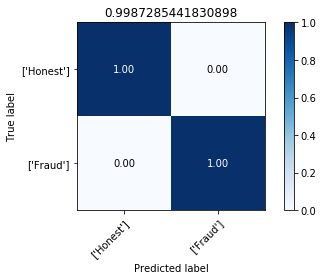

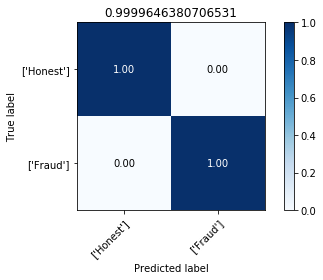

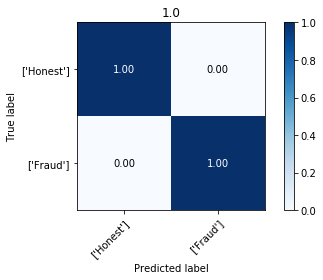

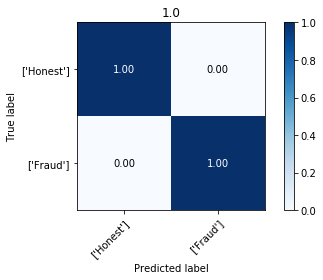

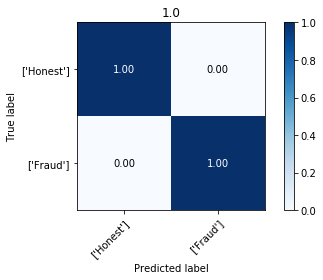

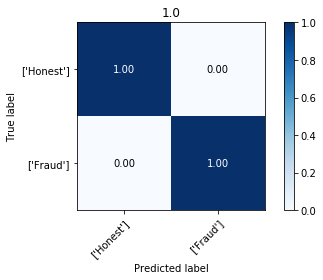

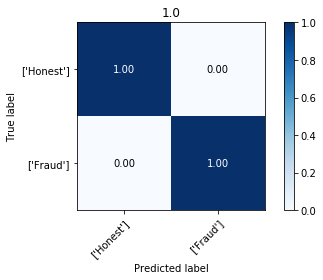

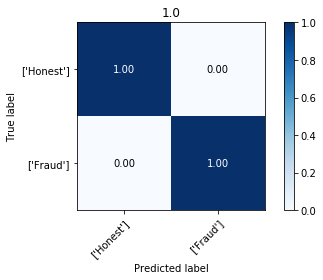

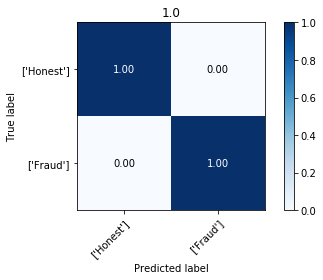

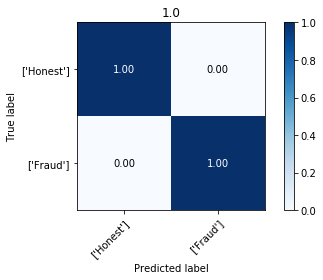

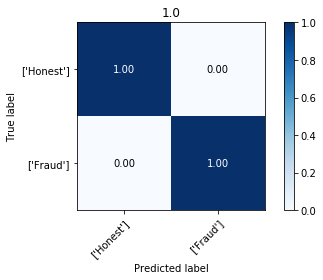

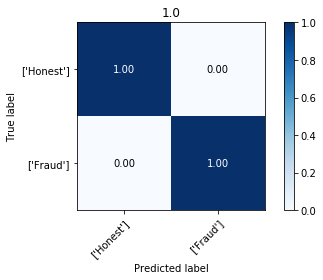

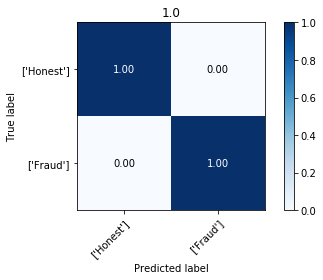

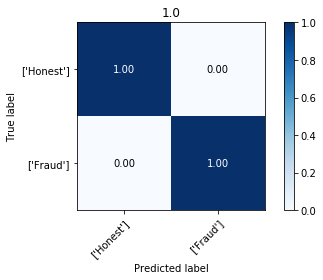

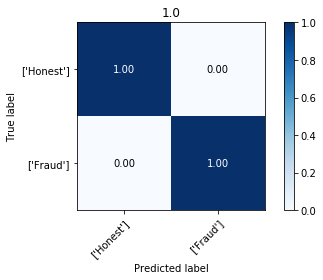

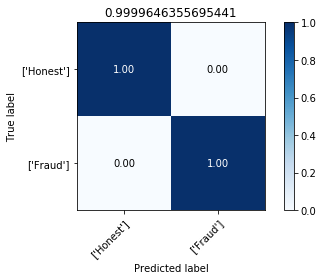

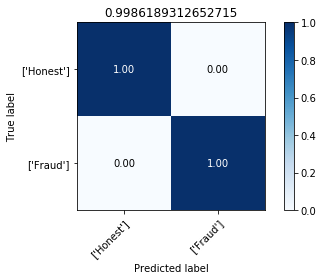

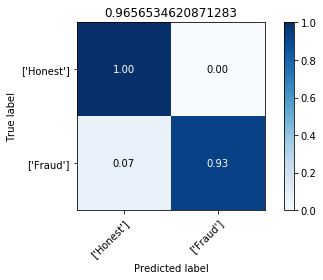

In [17]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [18]:
K.clear_session()

In [19]:
model1 = models.Sequential()
model1.add(layers.Dense(units = 50, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(units = 50, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model1.add(layers.Dropout(0.2))
model1.add(layers.Dense(units = 1,activation = 'sigmoid'))
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


In [20]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model1.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model1.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

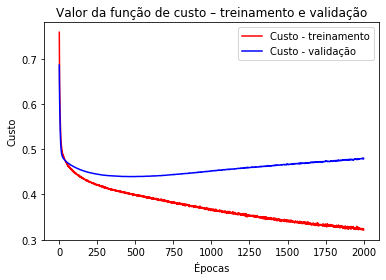

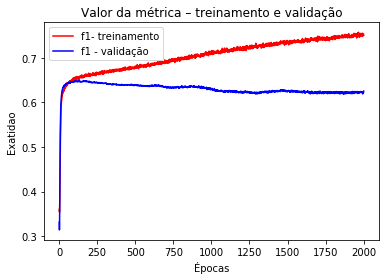

In [21]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [22]:
prob = np.ravel(model1.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

In [23]:
print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.5406696690816526, 0.605050279329609, 0.6581493425948896, 0.7069304766069087, 0.7483782657858715, 0.7835389360061681, 0.8160149233107641, 0.8454268065788495, 0.8692480359147026, 0.8924171438486899, 0.9098591549295775, 0.9268668998148529, 0.9390480538751285, 0.9531733746130031, 0.9640673922767258, 0.9758374519494784, 0.983659321614261, 0.9915891987605135]
recall values: [0.9764481222151495, 0.9574934578117265, 0.938185161609732, 0.9147747365443101, 0.8893839734068888, 0.8625079567154679, 0.8353490345851899, 0.8034514463540562, 0.7668859183817809, 0.727491336020935, 0.6853384256312327, 0.6373152273852465, 0.5818657613692623, 0.5225970719287079, 0.45731664191244076, 0.37704222363674944, 0.28099582714477683, 0.15842704575995473]
f1 values: [0.695972173211675, 0.7415237990907598, 0.773604712194553, 0.7975335285956529, 0.8128110658651672, 0.8211291788708212, 0.8255687973997833, 0.8239048447925734, 0.8148649156427309, 0.801558542762517, 0.7817983783129614, 0.75529106072670

Normalized confusion matrix
[[0.62660767 0.37339233]
 [0.02355188 0.97644812]]
Normalized confusion matrix
[[0.71867439 0.28132561]
 [0.04250654 0.95749346]]
Normalized confusion matrix
[[0.78065707 0.21934293]
 [0.06181484 0.93818516]]
Normalized confusion matrix
[[0.8293009  0.1706991 ]
 [0.08522526 0.91477474]]
Normalized confusion matrix
[[0.86540176 0.13459824]
 [0.11061603 0.88938397]]
Normalized confusion matrix
[[0.89274799 0.10725201]
 [0.13749204 0.86250796]]
Normalized confusion matrix
[[0.91522348 0.08477652]
 [0.16465097 0.83534903]]
Normalized confusion matrix
[[0.93387877 0.06612123]
 [0.19654855 0.80345145]]
Normalized confusion matrix
[[0.94807717 0.05192283]
 [0.23311408 0.76688592]]
Normalized confusion matrix
[[0.96052464 0.03947536]
 [0.27250866 0.72749134]]
Normalized confusion matrix
[[0.96943843 0.03056157]
 [0.31466157 0.68533843]]
Normalized confusion matrix
[[0.97736534 0.02263466]
 [0.36268477 0.63731523]]
Normalized confusion matrix
[[0.98300013 0.01699987]

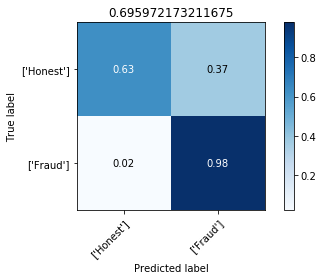

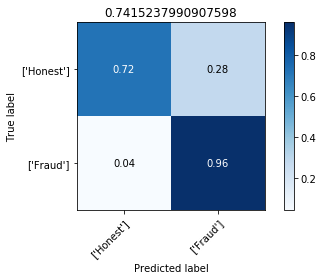

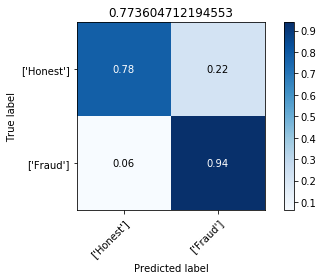

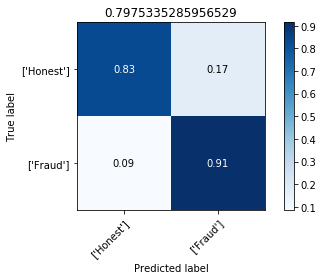

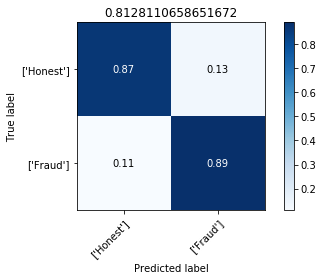

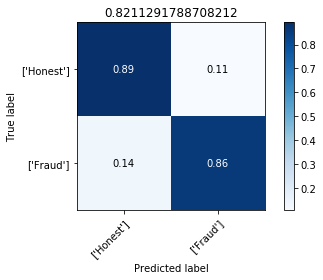

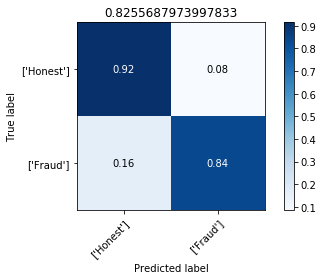

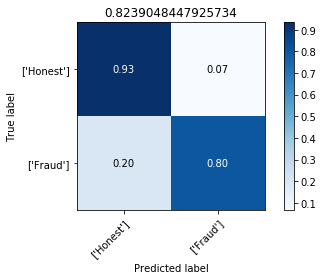

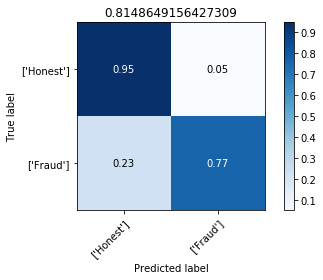

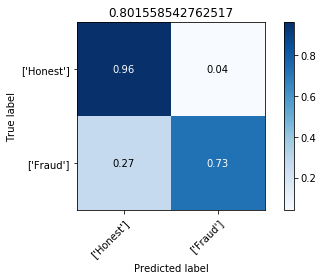

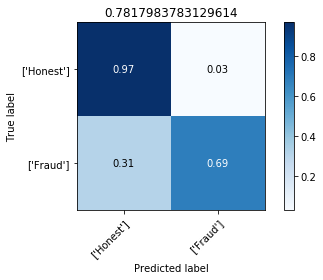

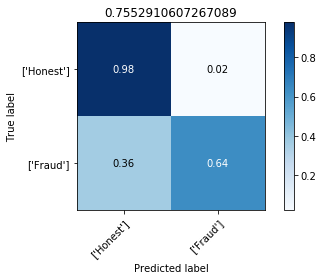

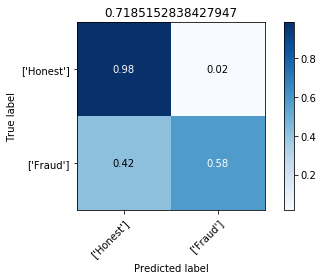

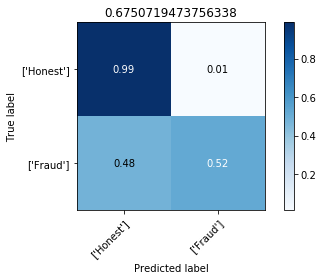

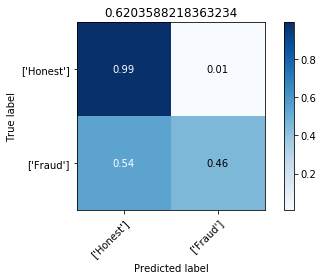

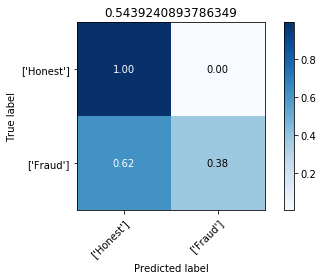

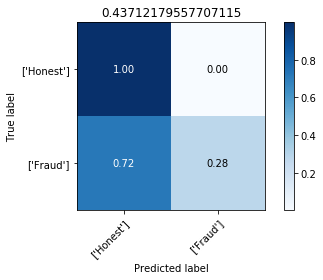

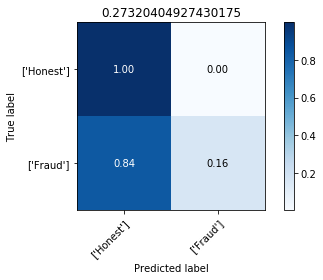

In [24]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [25]:
K.clear_session()

In [26]:
model2 = models.Sequential()
model2.add(layers.Dense(units = 50, activation='tanh',input_shape = (200,)))
BatchNormalization(axis=1)
model2.add(layers.Dropout(0.1))
model2.add(layers.Dense(units = 50, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model2.add(layers.Dropout(0.3))
model2.add(layers.Dense(units = 1,activation = 'sigmoid'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


In [27]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model2.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model2.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

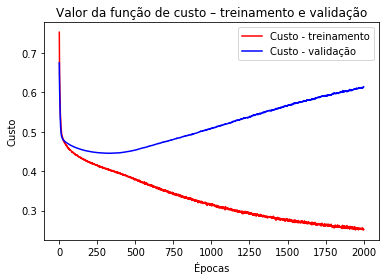

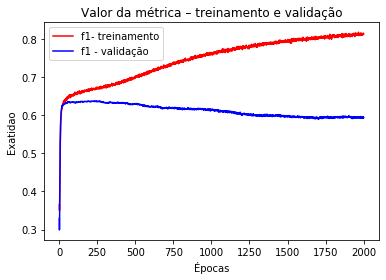

In [28]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [29]:
prob = np.ravel(model2.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

In [30]:
print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.6316552630386515, 0.6997464503042596, 0.7513778659611993, 0.7961417835374874, 0.8323390894819466, 0.8624065621485745, 0.8866101223581757, 0.9083930399181167, 0.9243280390959071, 0.9374650587013816, 0.9497014046597695, 0.9612396177547557, 0.9703426432479124, 0.9785900783289817, 0.9860885694412242, 0.9897442727757059, 0.9934885235227088, 0.9986062717770035]
recall values: [0.9859254544168612, 0.9759530376971497, 0.9642124619845817, 0.9515524435957281, 0.9374778980125893, 0.9220595515948794, 0.901973265436028, 0.8787750194497489, 0.856142584341184, 0.8301860103260486, 0.7985713275337718, 0.7612278096046396, 0.7150434967112242, 0.6627059905226678, 0.6015984157295424, 0.525567579036707, 0.43164297333616236, 0.3040526204116274]
f1 values: [0.7699955810870527, 0.8150860923240498, 0.844593129510888, 0.866937302661254, 0.8817855242150079, 0.8912359857806946, 0.8942257125828279, 0.8933386058884855, 0.8889296860657242, 0.8805701425356339, 0.8676041186414629, 0.849621092516577

Normalized confusion matrix
[[0.74121355 0.25878645]
 [0.01407455 0.98592545]]
Normalized confusion matrix
[[0.81150516 0.18849484]
 [0.02404696 0.97595304]]
Normalized confusion matrix
[[0.85639246 0.14360754]
 [0.03578754 0.96421246]]
Normalized confusion matrix
[[0.89032854 0.10967146]
 [0.04844756 0.95155244]]
Normalized confusion matrix
[[0.91500064 0.08499936]
 [0.0625221  0.9374779 ]]
Normalized confusion matrix
[[0.93378327 0.06621673]
 [0.07794045 0.92205955]]
Normalized confusion matrix
[[0.94807717 0.05192283]
 [0.09802673 0.90197327]]
Normalized confusion matrix
[[0.96011079 0.03988921]
 [0.12122498 0.87877502]]
Normalized confusion matrix
[[0.96845155 0.03154845]
 [0.14385742 0.85614258]]
Normalized confusion matrix
[[0.97507322 0.02492678]
 [0.16981399 0.83018601]]
Normalized confusion matrix
[[0.98096269 0.01903731]
 [0.20142867 0.79857133]]
Normalized confusion matrix
[[0.98618362 0.01381638]
 [0.23877219 0.76122781]]
Normalized confusion matrix
[[0.990163  0.009837 ]
 

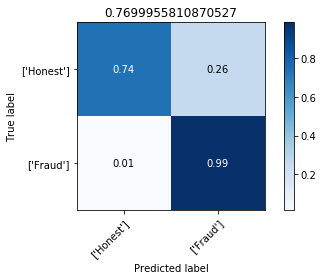

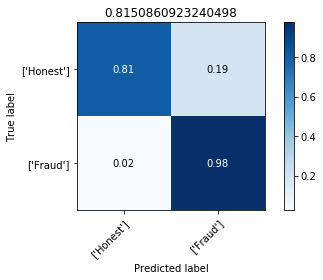

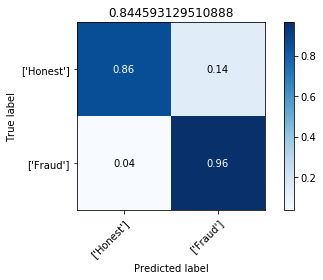

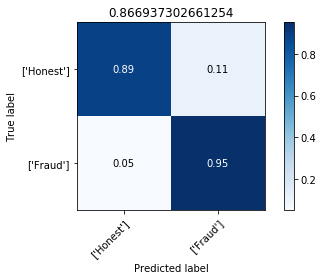

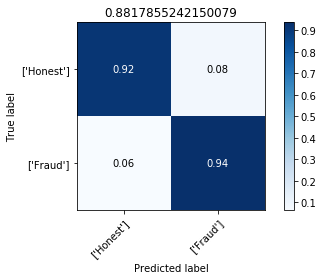

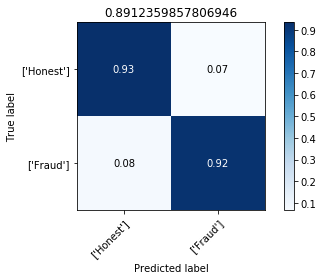

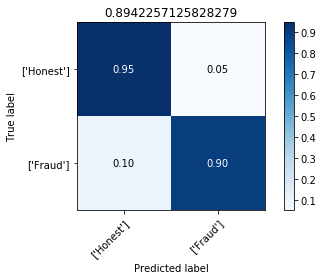

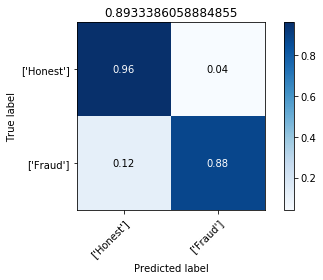

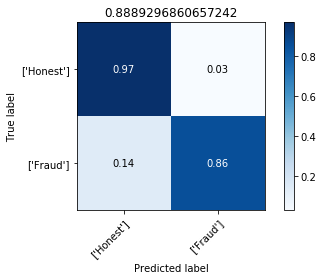

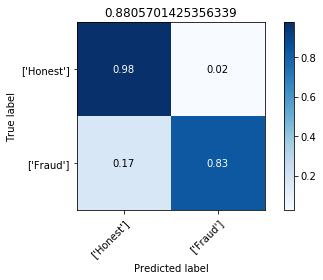

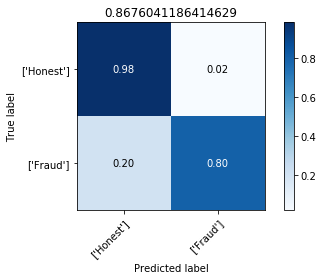

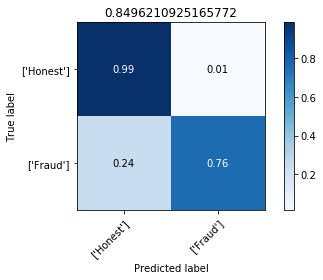

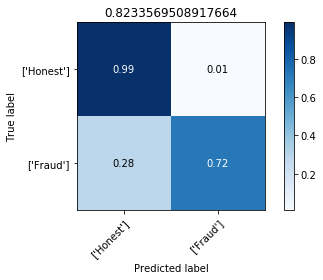

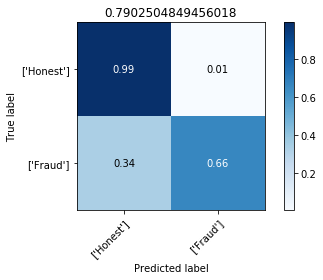

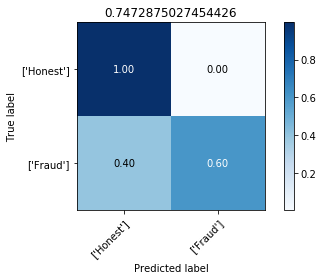

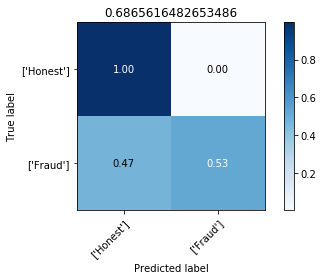

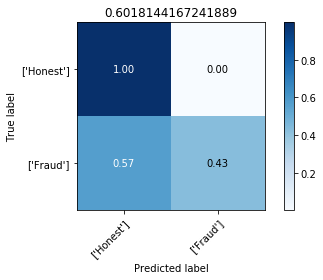

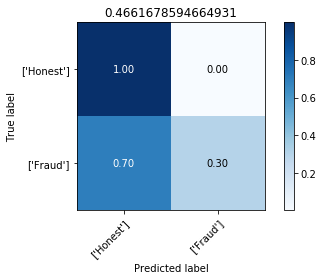

In [31]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [32]:
K.clear_session()

In [33]:
model3 = models.Sequential()
model3.add(layers.Dense(units = 50, activation='tanh',input_shape = (200,),
                        kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(units = 50, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(units = 1,activation = 'sigmoid'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


In [34]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model3.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model3.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

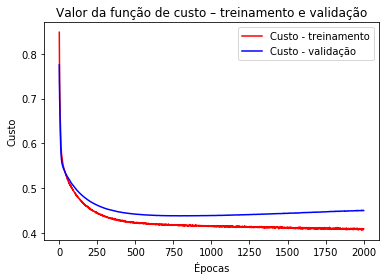

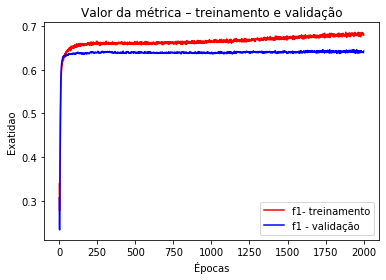

In [35]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

precision values: [0.4626399728537496, 0.520099510345917, 0.5709081095668601, 0.6150669755262362, 0.6552902936561309, 0.6928642714570858, 0.724332896642074, 0.7575687897600981, 0.7884304551254785, 0.8129148492319362, 0.8390669932900202, 0.8621151271753681, 0.8847991008710312, 0.9075393537696769, 0.927007299270073, 0.944591728525981, 0.9677938808373591, 0.9876434245366285]
recall values: [0.9642831883442959, 0.9315368837965909, 0.8977296838531721, 0.8638517575500388, 0.8270033241389065, 0.7856284037060612, 0.7429804087983591, 0.6990593394158002, 0.6554919018318127, 0.6063370818303981, 0.5571822618289837, 0.5010255322158569, 0.44543461348044416, 0.38736827215503217, 0.3233609166136219, 0.251998019661928, 0.1700261687530943, 0.0791427965202631]
f1 values: [0.6252837716985026, 0.6675113397359552, 0.6979544704717916, 0.7185339882930847, 0.7312009505049558, 0.7363362168970203, 0.7335381607429647, 0.7271389685867726, 0.7158415076851781, 0.6945918574032812, 0.6696701802108127, 0.63374485596707

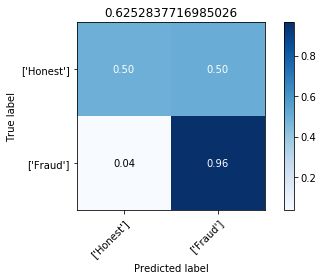

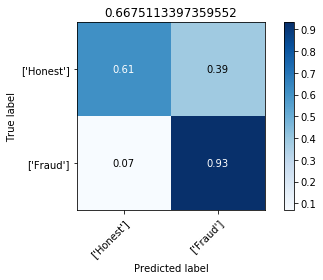

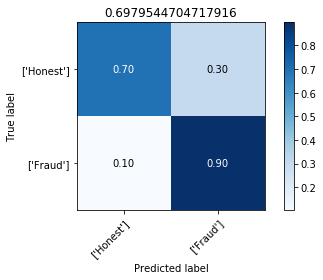

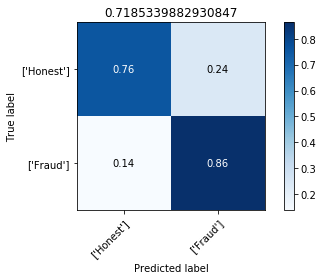

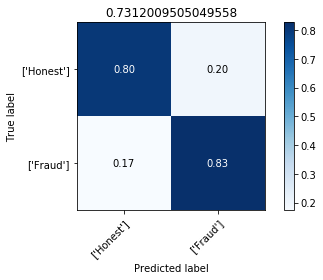

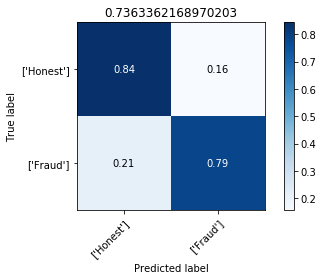

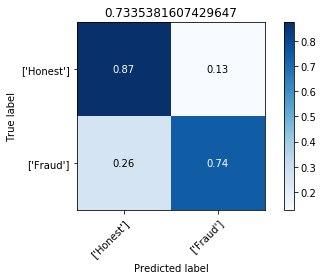

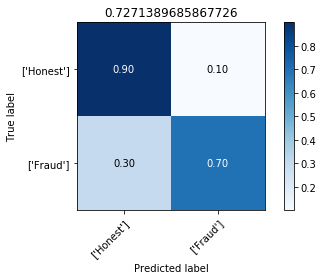

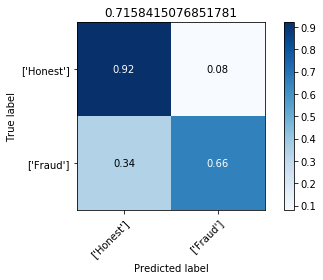

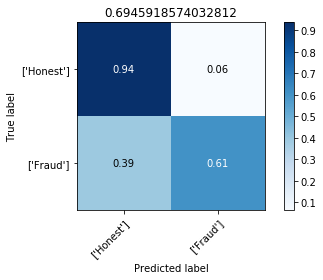

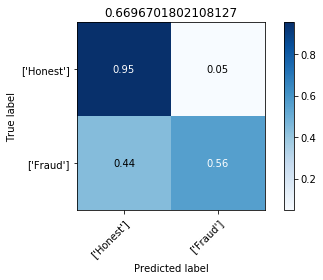

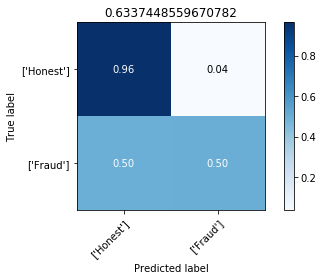

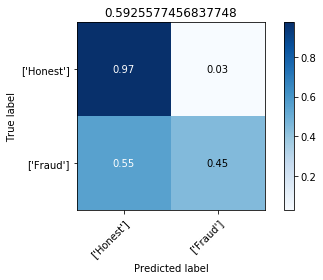

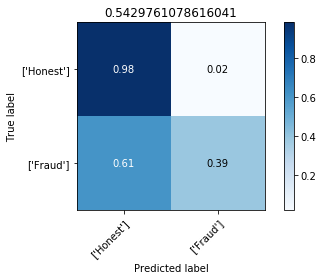

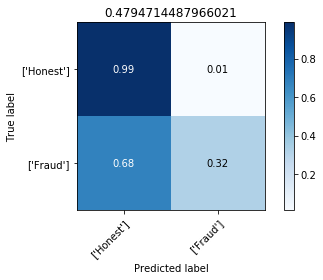

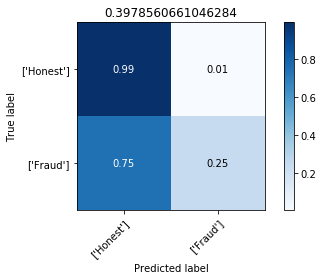

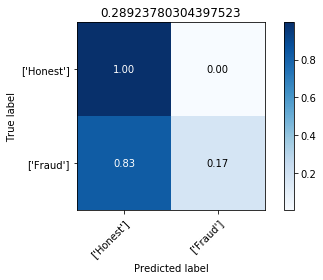

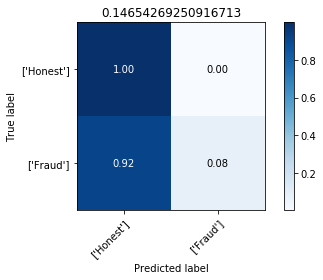

In [36]:
prob = np.ravel(model3.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [37]:
K.clear_session()

In [38]:
model4 = models.Sequential()
model4.add(layers.Dense(units = 50, activation='tanh',input_shape = (200,),
                        kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model4.add(layers.Dropout(0.2))
model4.add(layers.Dense(units = 50, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model4.add(layers.Dropout(0.2))
model4.add(layers.Dense(units = 1,activation = 'sigmoid'))
model4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


In [39]:
adam = optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, decay=0.0)
model4.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = adam)
history = model4.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

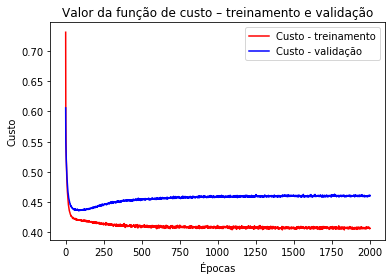

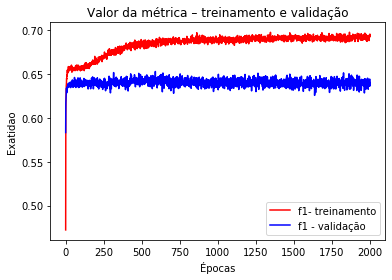

In [40]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

precision values: [0.4734879867439934, 0.5337162135025503, 0.5868375444677552, 0.6321528662420383, 0.6728353140916808, 0.7098642421223066, 0.7425281052920208, 0.7727649318370113, 0.8011632737847943, 0.826651921481891, 0.8490022629088665, 0.8719767441860465, 0.8923527844391154, 0.9097802537913958, 0.9292967280932681, 0.9474957657875636, 0.9669909659485754, 0.9881944444444445]
recall values: [0.9700827498408657, 0.9398825942428743, 0.9100360704434542, 0.8774312186151779, 0.8408656906429026, 0.8062097743829125, 0.7661079284249239, 0.7256524506683641, 0.681943560364948, 0.6344154466369616, 0.5837753730815475, 0.530376971497277, 0.47372515736615034, 0.4158002687601669, 0.3495296697079001, 0.27696442464106374, 0.1968314590848009, 0.10064360987339982]
f1 values: [0.6363699631150393, 0.6808238126953224, 0.7135449882157215, 0.7348655372586186, 0.747524285579553, 0.7549756598337584, 0.7541337417760294, 0.748468047855267, 0.7367616718881332, 0.7178871548619448, 0.6918402413980974, 0.6595716610229

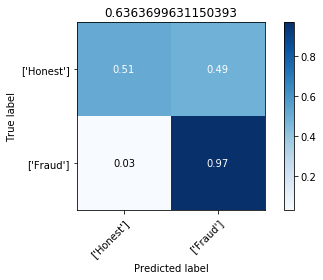

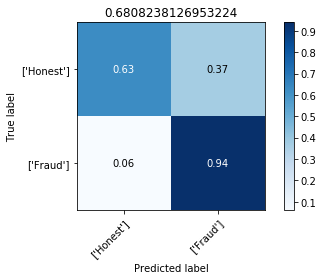

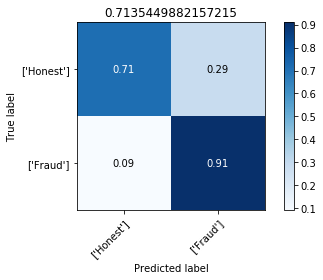

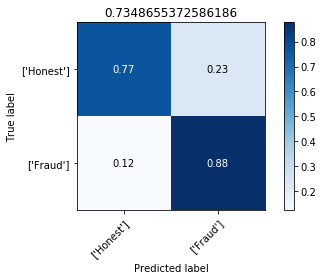

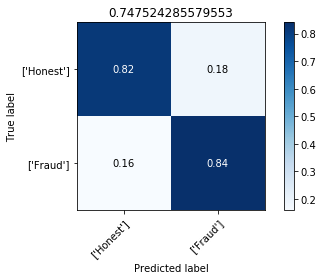

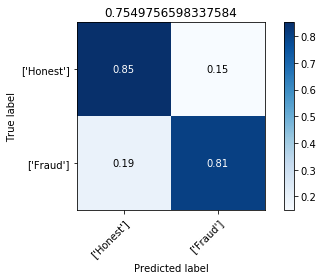

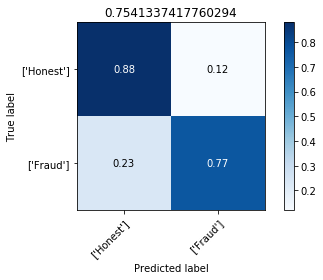

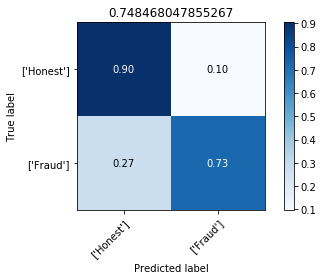

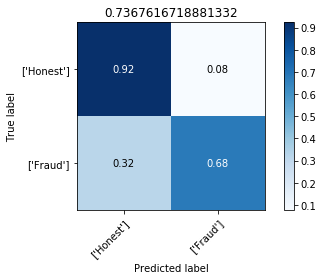

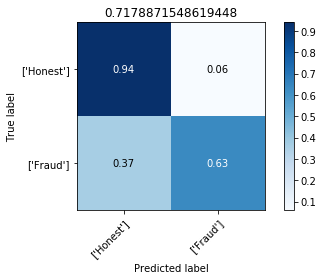

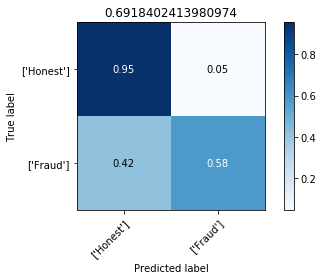

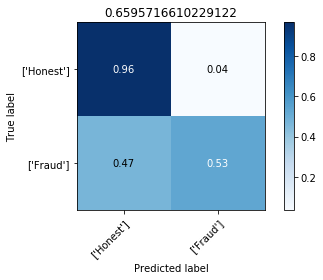

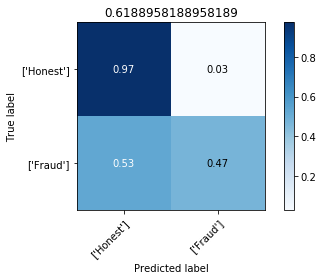

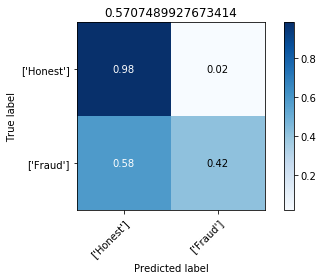

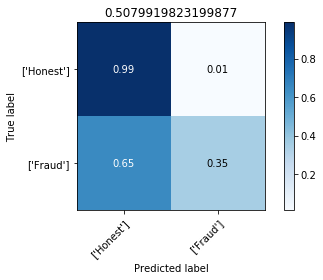

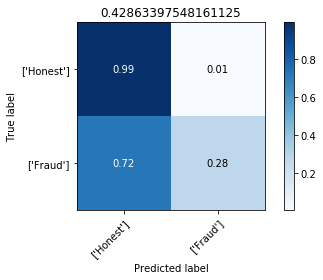

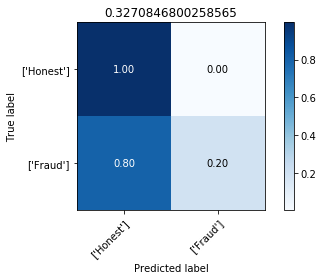

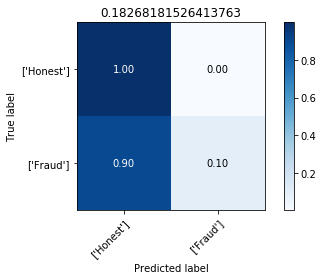

In [41]:
prob = np.ravel(model4.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [42]:
K.clear_session()

In [43]:
model5 = models.Sequential()
model5.add(layers.Dense(units = 50, activation='tanh',input_shape = (200,),
                        kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model5.add(layers.Dropout(0.2))
model5.add(layers.Dense(units = 50, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model5.add(layers.Dropout(0.2))
model5.add(layers.Dense(units = 1,activation = 'sigmoid'))
model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 12,651
Trainable params: 12,651
Non-trainable params: 0
_________________________________________________________________


In [44]:
rms = optimizers.RMSprop(lr=0.0001, rho=0.99, decay=0.0)
model5.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = rms)
history = model5.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

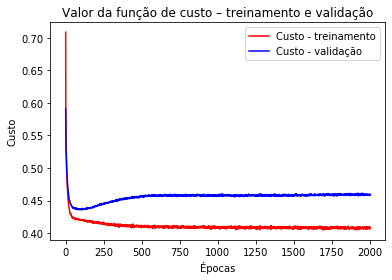

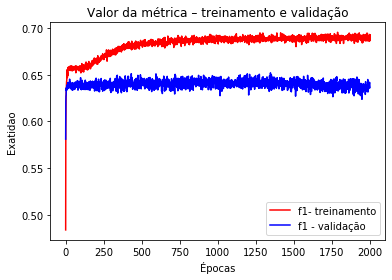

In [45]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

precision values: [0.4814135571700642, 0.542860666858529, 0.5957217749485115, 0.643451691075756, 0.6846815230742236, 0.7191003995360227, 0.7526112462440979, 0.7833781008058145, 0.8115663492618154, 0.8364362998342918, 0.8571895781096697, 0.8764611787867602, 0.8993621545003544, 0.9199933466400533, 0.9349183961313722, 0.9544383346425765, 0.9734717416378316, 0.9903225806451613]
recall values: [0.9654148100997242, 0.9338708536671617, 0.9001343800834571, 0.8638517575500388, 0.8279227668151921, 0.7892354480514888, 0.7440413041940731, 0.7013225829266567, 0.6570478817455265, 0.6069028927081123, 0.5561213664332697, 0.5037838602447132, 0.4487587523870146, 0.39118749557960253, 0.3281703090741919, 0.25779758115849777, 0.17907914279652026, 0.08685196972911804]
f1 values: [0.6424587579130681, 0.6865997608028704, 0.716953496887587, 0.7375381178104525, 0.7495197848636189, 0.7525373436288229, 0.7483017391613614, 0.7400828450946001, 0.7261783788009067, 0.7034183129764734, 0.6745881949210707, 0.6398095751

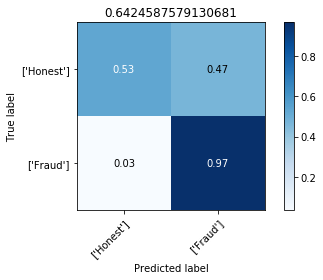

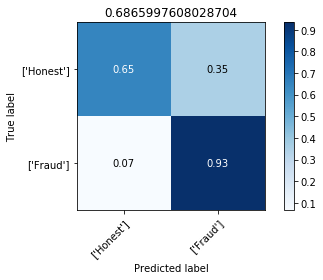

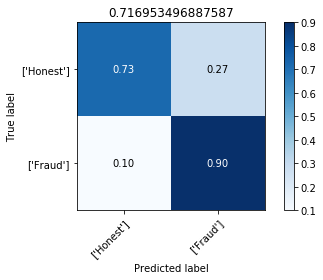

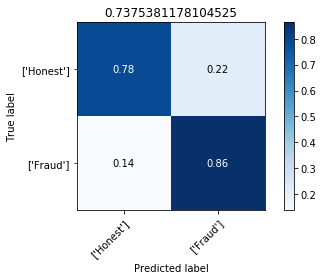

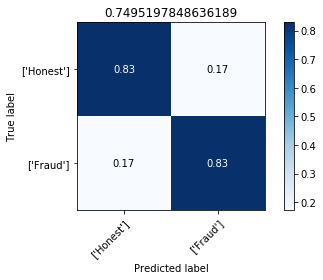

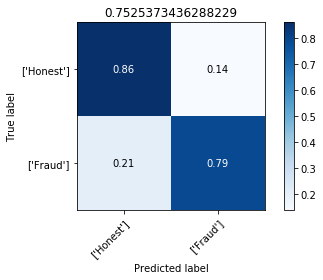

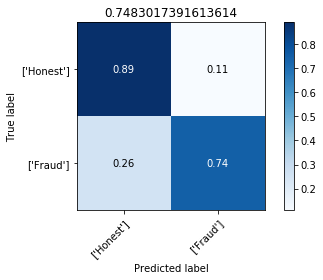

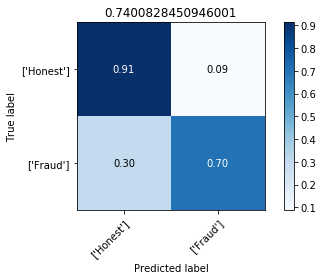

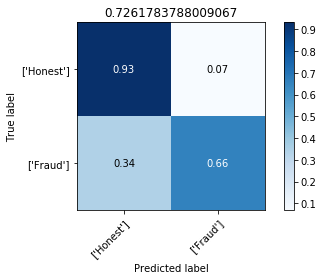

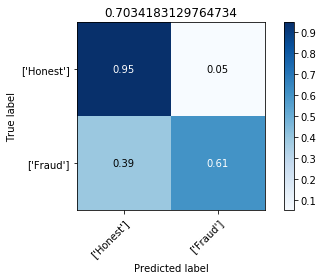

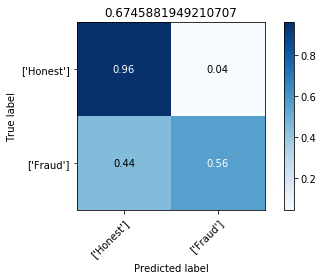

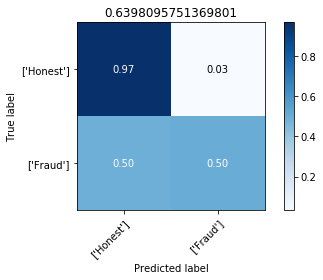

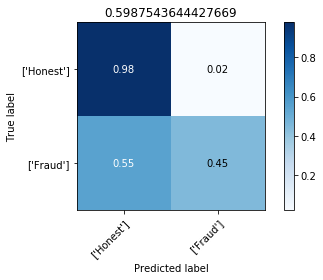

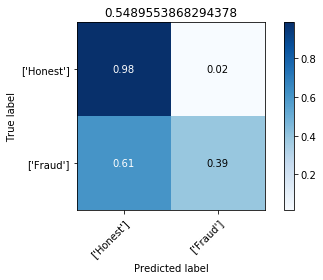

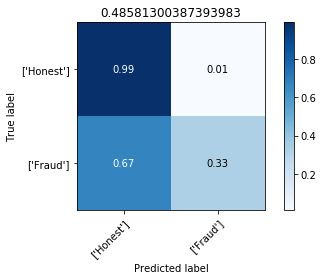

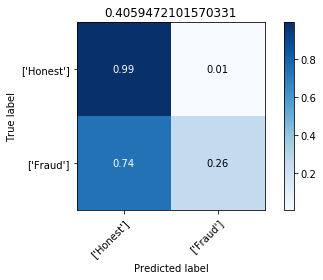

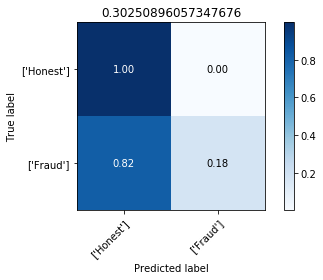

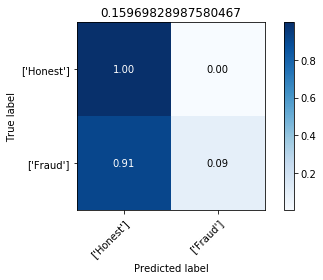

In [46]:
prob = np.ravel(model5.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)

print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)